## This file is for the penultimate development of this 4-Level Model

##### TRAINING SUBSECTION

In [ ]:
'''NOTE Load in the training data for level-0 models'''

import _Data_Processing
import joblib
from importlib import reload

'''
this function returns 7 objects:
	data: sets of data as X_train, X_val, X_ind, y_train, y_val, y_ind
	feature_list: list of all feature names with a column index (dict)
'''

reload(_Data_Processing)

lstm_format = False

X, X_train, X_val, X_ind,\
y, y_train, y_val, y_ind,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_large.csv'
	,indp_size  =		0.01
	,test_size  =		0.20
	,shfl_splt	=		False
	,t_start    =		570
	,t_end		=		720
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
	,optm_data	=		True
    ,indices	=		0
)
joblib.dump(scaler, 'scaler/tmp.joblib')

In [ ]:
'''NOTE Shred the data to run parallel to desired level-0 structure'''

import _Data_Rotating
from importlib import reload
'''
This function returns 4 items.
-	2D array of X partitions, by featurespace and samplespace
-	1D array of index-lists for each featurespace-partition specific features
-	1D array of featurespace-partition specific rotation transformer functions
-	1D array of y partitions for each samplespace partition.
'''

reload(_Data_Rotating)

X_train_parts, X_find_parts, X_trans_parts, y_parts = _Data_Rotating.rotate_partitions(
	X				=	X_train
	,y				=	y_train
	,n_feat_parts	=	8
	,feat_subsets	=	feature_subsets
	,feat_part_type	=	'by_subset'
	,fraction_feats	=	0.85
	,no_feat_overlap=	False
	,feats_for_all	=	[]
	,rotation_type	=	'PCA'
	,rotation_filter=	True
	,filter_type	=	'Retention'
	,filter_value	=	0.95
	,n_sample_parts	=	1
	,smpl_part_type	=	'Even'
	,sample_overlap	=	0.9
	,sample_shuffle	=	False
	,lstm_format	=	lstm_format
)

In [ ]:
'''NOTE Begin training for each level-0 model'''

import _Modelset_Training
from importlib import reload

'''
Function returns a 3D list of trained models that are fit to the resepective dataset.
	Dim1:	Featurespace, here are the subsetctions/partitions for each unique set of features
	Dim2:	Samplespace, here are the subsetctions/partitions for each unique set of samples
	Dim3:	Modelspace, here are the individual models trained on a unique partition
'''
reload(_Modelset_Training)

models = _Modelset_Training.train_models(
	model_types	=	['nn']
	,data_parts	=	X_train_parts
	,findx_parts=	X_find_parts
	,trans_parts=	X_trans_parts
	,trgt_parts	=	y_parts
	,X_valid	=	X_val
	,y_valid	=	y_val
	,param_mode	=	'custom'
	,cst_mod_prm=	[{
		'optimizer_type'	:	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.00025
			#,'momentum'		:	0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	7
		,'rlr_patience'		:	20
		,'architecture'	:	'default_deep'
		#,'external_cw'	:	_Utility.get_class_weights(y_train)
		}]
	,tnr_verbose=	True
	,lstm_frmt	=	lstm_format
	,use_cls_wt	=	True
)

In [ ]:
'''NOTE show performances of level-0 Models'''

import _Model_Evaluation
import _Neural_Net

reload(_Model_Evaluation)
reload(_Neural_Net)

_Model_Evaluation.evaluate_models(
		models=models
		,X_findx=X_find_parts
		,X_trans=X_trans_parts
		,X_train=X_train_parts
		,y_train=y_parts
		,X_test=X_val
		,y_test=y_val
		,prfm_gnrl	=	'all'
		,prfm_stat	=	'all'
		,disp_mthd	=	'as_value'
		,test_whch	=	'independent'
		,pred_type	=	'classification'
		,lstm_frmt	=	lstm_format
)

In [ ]:
'''NOTE begin training for level-1 model based off of train level-0 model predictions'''

import _Metamodel
from importlib import reload
import _Utility

reload(_Metamodel)

metamodel, prediction_set = _Metamodel.train_test_meta_model(
	models		=	models
	,X_findx	=	X_find_parts
	,X_trans	=	X_trans_parts
	,X_test		=	X_val
	,y_test		=	y_val
	,val_size	=	0.2
	,shuffle	=	True
	,metam_type =	'NN'
	,use_cls_wt =	True
	,use_mm_params=	True
    ,meta_scaler=	'Standard'
	,metam_params={
		'optimizer_type':	'Adam'
		,'optimizer_kwarg':{
			'learning_rate'	:	0.00025
            #,'weight_decay'	:	0.001
			#,'momentum':0.9
			}
		,'time_steps'		:	5
		,'LSTM'				:	False
		,'shuffle_train'	:	True
		,'epochs'			:	75
		,'batch_size'		:	30
		,'rlr_patience'		:	10
		,'architecture'	:	'default_deep'
		#,'custom_val_data'	:	(X_train, y_train)
		}
)

In [ ]:
'''NOTE load in data for testing quality of level-1/2 models'''

import _Data_Processing
from importlib import reload
reload(_Data_Processing)
lstm_format = False
X_test, _, _, __,\
y_test, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		645
	,t_end		=		800
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Custom'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,indices	=		0
)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import _Master_Model
reload(_Master_Model)
reload(_Utility)
from importlib import reload
from sklearn.svm import SVC
from _Utility import get_class_weights

shallow_master = _Master_Model.Master(
	model_depth		=	2
	,all_models 	=	[models, metamodel]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
	,lvl1_formatters=	[joblib.load('scaler/meta.joblib')]
)

X_blvl2 = X_val
y_blvl2 = y_val

pred_2 = shallow_master.master_predict(X_blvl2, mode='proba')
cm_vals = _Utility.get_cm_values(y_blvl2, pred_2)

_Utility.show_confusion_matrix(y_blvl2,pred_2,title=f'Level-1 Prediction\nPrecision: {round(precision_score(y_blvl2,pred_2)*100, 2)}%')

df = pd.DataFrame(X_blvl2)
df['score'] = cm_vals
df['target'] = y_blvl2
kept_indices = df.index[~(df['score'] % 2 == 0)].tolist()
df = df.drop(df[df['score']%2==0].index).reset_index(drop=True)
df = df.drop(columns=['score']).reset_index(drop=True)
#pd.set_option('display.max_rows',None)
co = df.corr()['target'].drop('target')
#print(co.sort_values())
p = co.nlargest(5).index.tolist()
n = co.nsmallest(5).index.tolist()
feats = p+n

df_pair = pd.DataFrame(X_blvl2)
df_pair = df_pair.iloc[kept_indices].reset_index(drop=True)
df_pair = df_pair.iloc[:, feats]

X_svm = df_pair.values
y_svm = df['target'].values

y_one = y_blvl2[kept_indices]

clf = SVC(kernel='linear',C=1.0,class_weight=_Utility.get_class_weights(y_one)).fit(X_svm, y_svm)

y_svmpred = pred_2#clf.predict(X_svm)
#'polishing' predictions based on if level-1 predicted (1)
for p in range(len(y_svmpred)):
	if(y_svmpred[p] == 1):
		y_svmpred[p] = clf.predict(X[p,feats].reshape(1, -1))

#_Utility.show_confusion_matrix(df['target'],y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_svm, y_svmpred)*100, 2)}%')
_Utility.show_confusion_matrix(y_blvl2,y_svmpred,title=f'Level-2 Prediction\nPrecision: {round(precision_score(y_blvl2, y_svmpred)*100, 2)}%')


In [ ]:
reload(_Master_Model)
reload(_Utility)
deep_master = _Master_Model.Master(
	model_depth		=	3
	,all_models 	=	[models, metamodel.model, clf]
	,lvl0_formatters=	[X_find_parts, X_trans_parts]
    ,lvl2_formatters=	[feats]
)

y_3pred = deep_master.master_predict(X_test)

_Utility.show_confusion_matrix(y_test, y_3pred, title=f'Accuracy: {_Utility.get_accuracy(y_test, y_3pred)}\nPrecision: {_Utility.get_precision(y_test, y_3pred)}')

In [ ]:
import _Master_Model
from importlib import reload
reload(_Master_Model)
#deep_master = _Master_Model.Master(model_depth=3)
#deep_master.load_model('pre63p2-645-800')
deep_master.save_model()

In [1]:
import _Time_Ensemble
import _Master_Model
import joblib
import _Utility

'''NOTE load in data for testing quality of level-1/2 models'''

import _Data_Processing
from importlib import reload
reload(_Data_Processing)
reload(_Master_Model)
reload(_Time_Ensemble)
lstm_format = False
X_te, _, _, __,\
y_te, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		600
	,t_end		=		950
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'Custom'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
    ,indices	=		0
)

chronos_array = _Time_Ensemble.chronos_predict(X_te,                                                           
['pre63p2-645-800','models/m55','models/m60','models/m50'])


2025-02-16 19:52:17.763301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 19:52:17.931394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739753538.000697     650 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739753538.020496     650 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 19:52:18.179332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

loaded chunk 1 of size: 125400164 -> 64675164
loaded chunk 2 of size: 31084316 -> 15932651
concat chunks
concatted chunks
Success.
Size of dataset:	80706803
	23295 Samples Dropped.



I0000 00:00:1739753543.002960     650 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1962 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Chronos: Predicting on Model #1 (pre63p2-645-800)


I0000 00:00:1739753546.938182     952 service.cc:148] XLA service 0x7fc9d400d800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739753546.938561     952 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capability 6.1
2025-02-16 19:52:26.948946: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739753547.008288     952 cuda_dnn.cc:529] Loaded cuDNN version 90300


129/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1739753547.497013     952 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(7902, 8)
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Chronos: Predicting on Model #2 (models/m55)
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(7902, 8)
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Chronos: Predicting on Model #3 (models/m60)
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 

<class 'numpy.ndarray'>


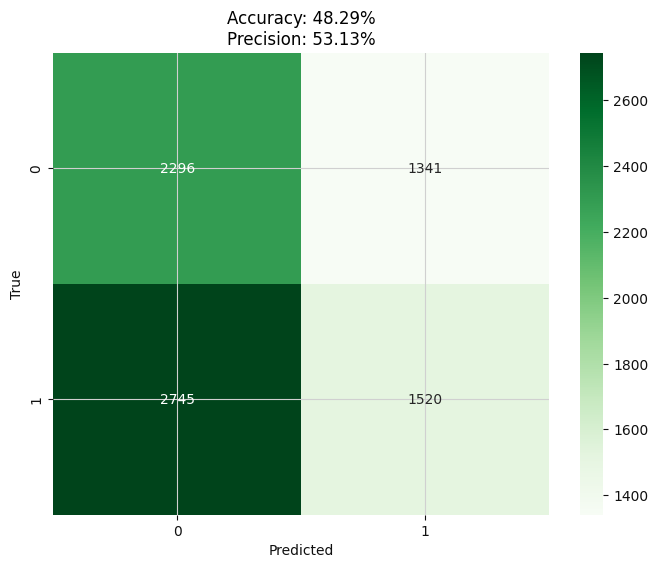

In [8]:
reload(_Utility)
reload(_Time_Ensemble)
print(type(chronos_array[0]))
t_pred	=	_Time_Ensemble.chronos_fusion(master_predictions=chronos_array, fusion_method='mv',vote_var=3)
_Utility.show_confusion_matrix(y_te, t_pred, title=f'Accuracy: {_Utility.get_accuracy(y_te, t_pred)}\nPrecision: {_Utility.get_precision(y_te, t_pred)}')

In [ ]:
#reload(_Utility)
#reload(_Time_Ensemble)
#vals = _Utility.graph_range(_Time_Ensemble.chronos_fusion, kw='vote_var', kw_range=range(0,5), show_graph=False, master_predictions=chronos_array,fusion_method='mv')
#scores = [precision_score(y_te, vals[i]) for i in range(0,5)]
#_Utility.plot_standard_line(scores, range(0,5))

In [ ]:
#from _Utility import get_name_from_fss
#get_name_from_fss(fss=feature_subsets,index=138)

In [ ]:
for fs in feature_subsets:
	print(fs)

In [ ]:
len(t_pred)

loaded chunk 1 of size: 125400164 -> 64675164
loaded chunk 2 of size: 31084316 -> 15932651
concat chunks
concatted chunks
Success.
Size of dataset:	80706803
	23295 Samples Dropped.

301 0
301 351
301 702
180 1053
301 1233
301 1584
301 1935
301 2286
301 2637
301 2988
301 3339
301 3690
301 4041
301 4392
301 4743
301 5094
301 5445
301 5796
301 6147
301 6498
301 6849
301 7200
301 7551
Plotting Features: ['hilo_stoch_240_120_spx']


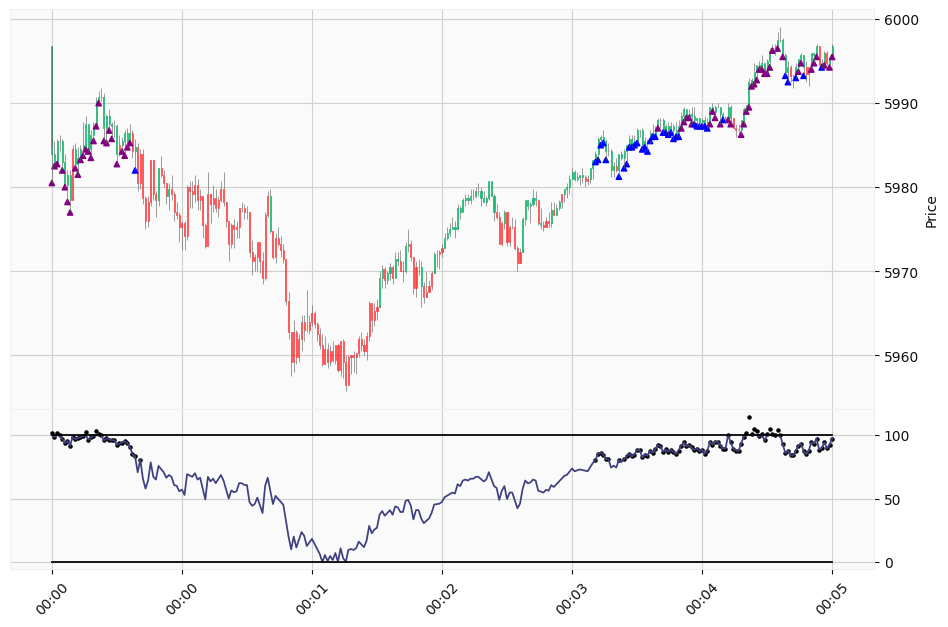

Plotting Features: ['hilo_stoch_240_120_spx']


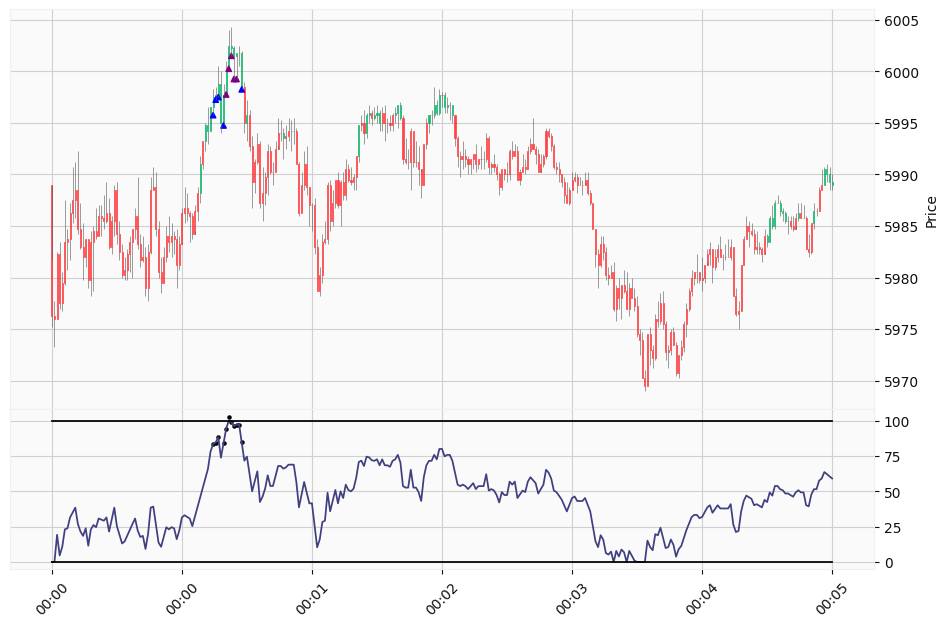

Plotting Features: ['hilo_stoch_240_120_spx']


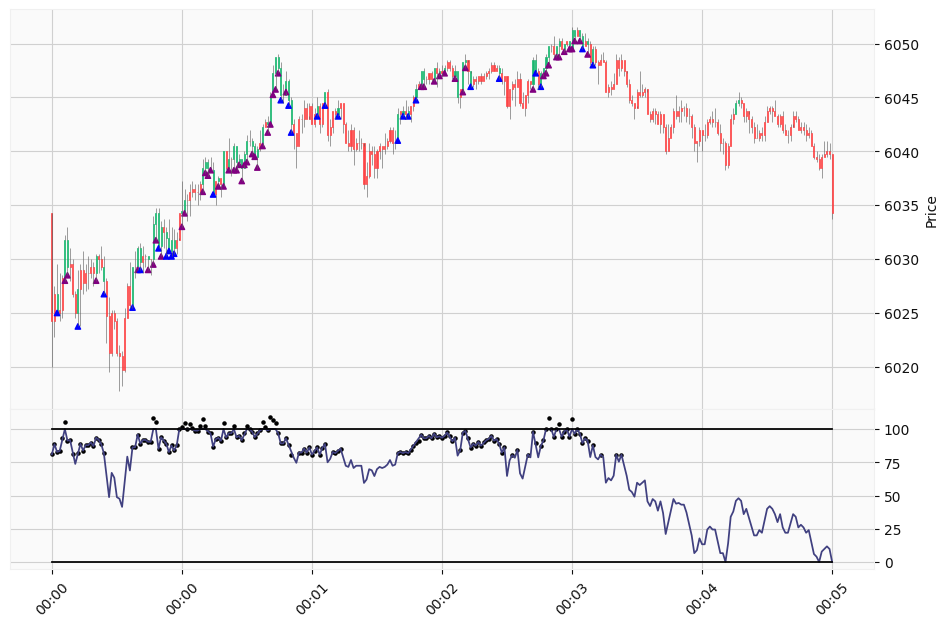

Plotting Features: ['hilo_stoch_240_120_spx']


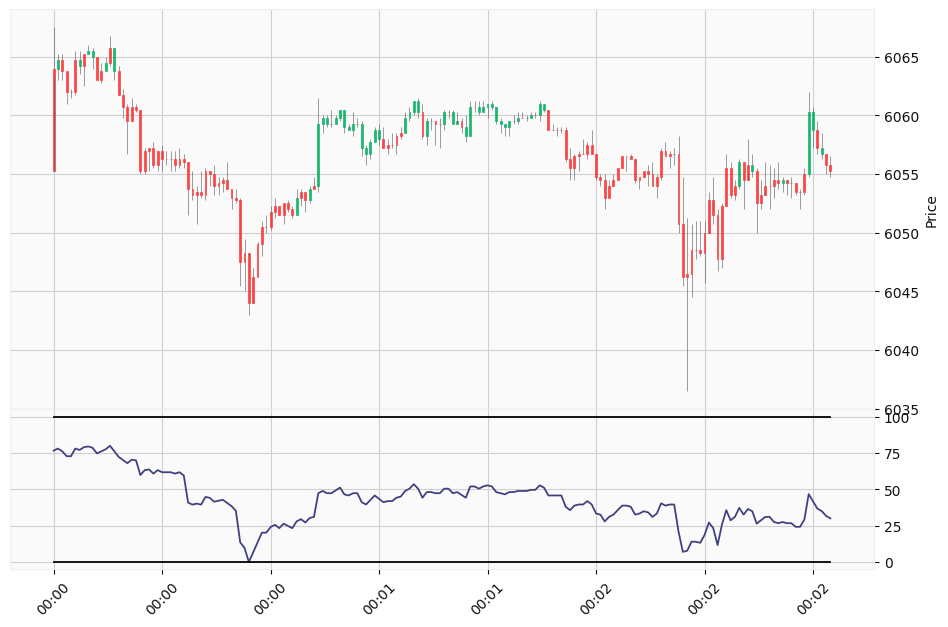

Plotting Features: ['hilo_stoch_240_120_spx']


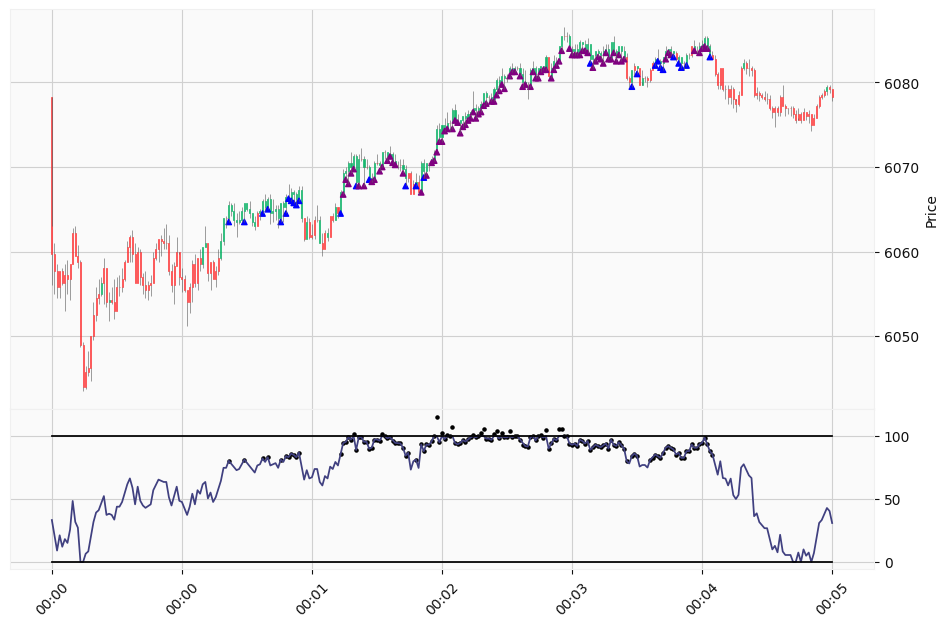

Plotting Features: ['hilo_stoch_240_120_spx']


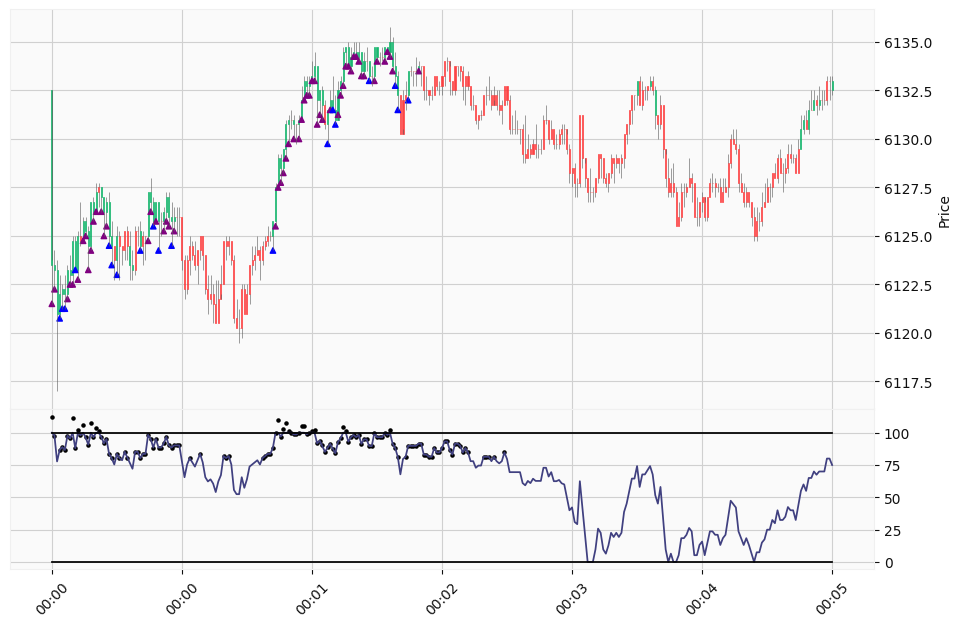

Plotting Features: ['hilo_stoch_240_120_spx']


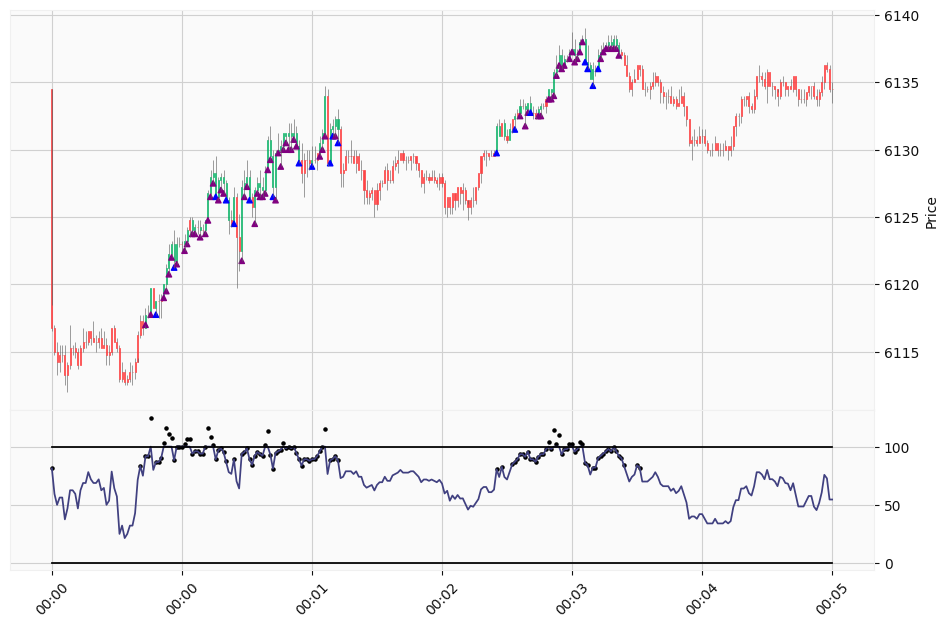

Plotting Features: ['hilo_stoch_240_120_spx']


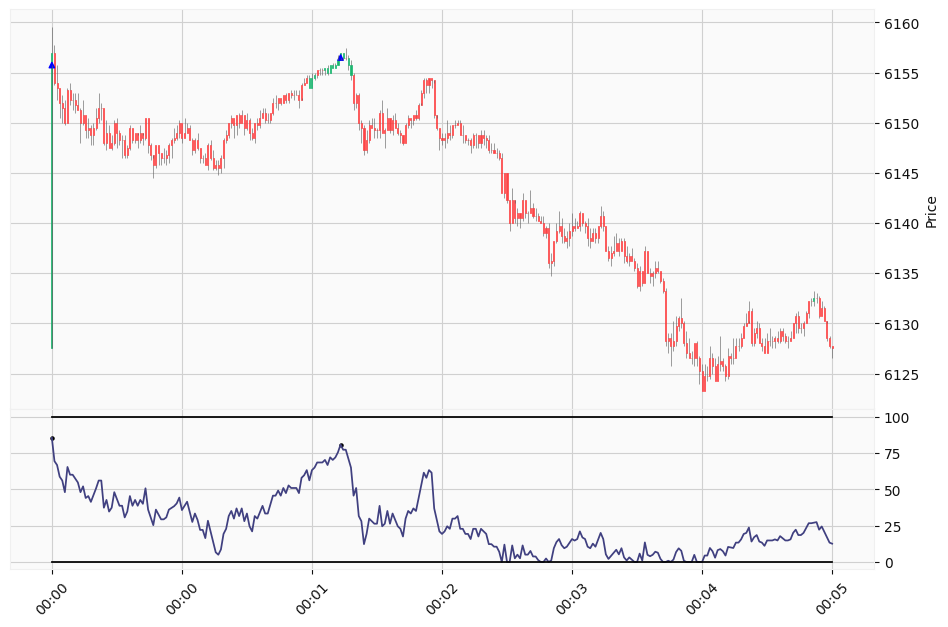

Plotting Features: ['hilo_stoch_240_120_spx']


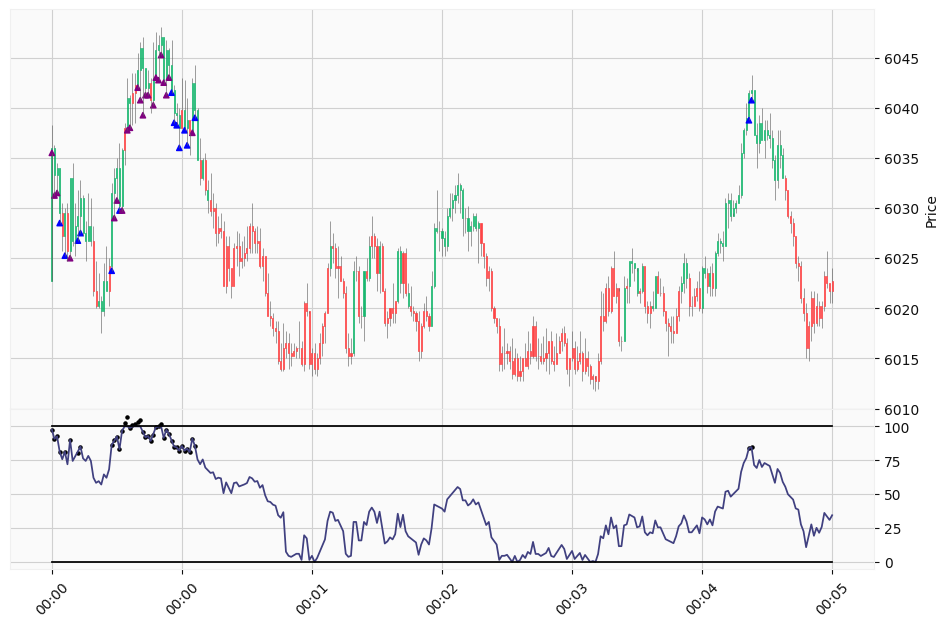

Plotting Features: ['hilo_stoch_240_120_spx']


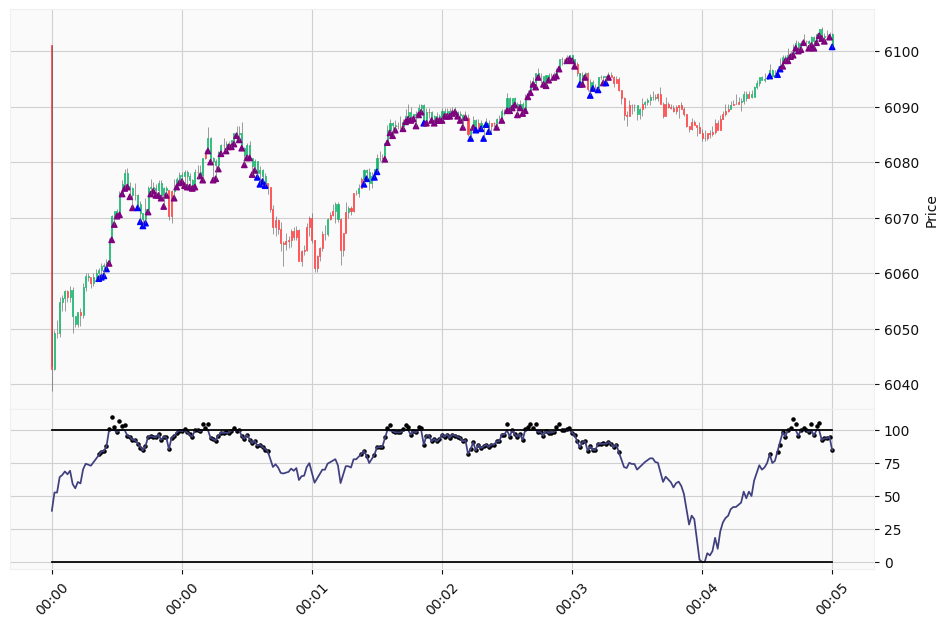

Plotting Features: ['hilo_stoch_240_120_spx']


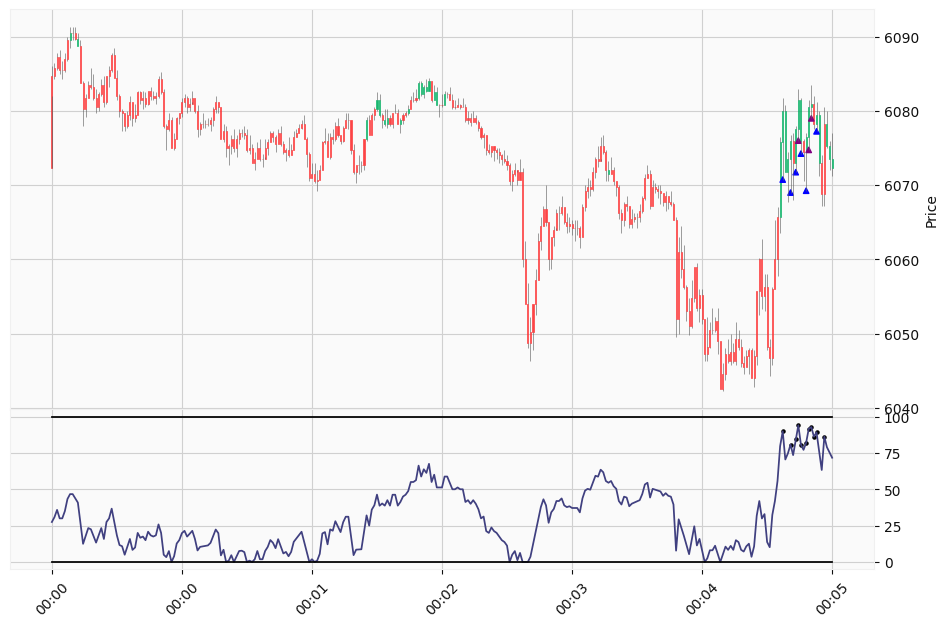

Plotting Features: ['hilo_stoch_240_120_spx']


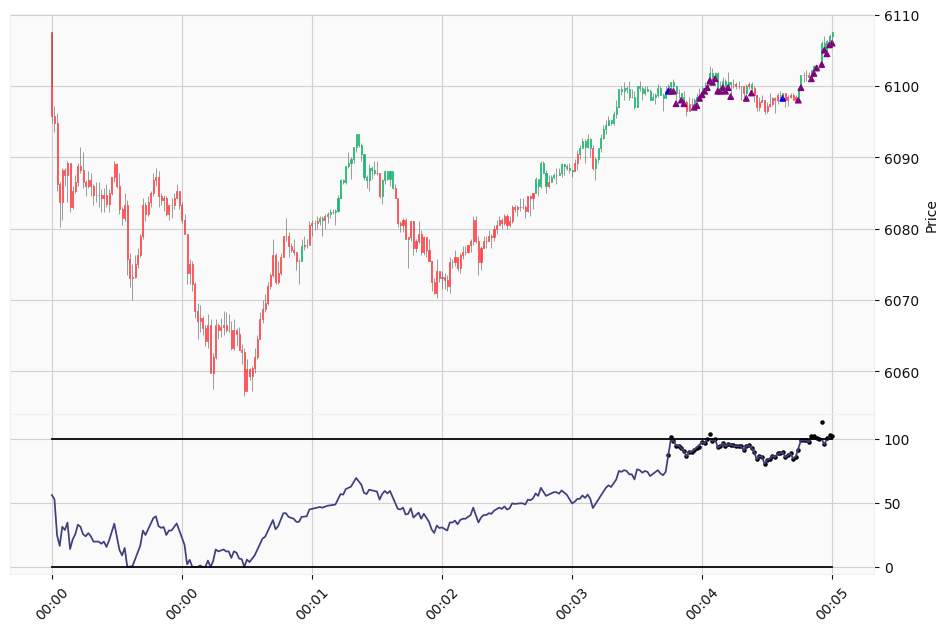

Plotting Features: ['hilo_stoch_240_120_spx']


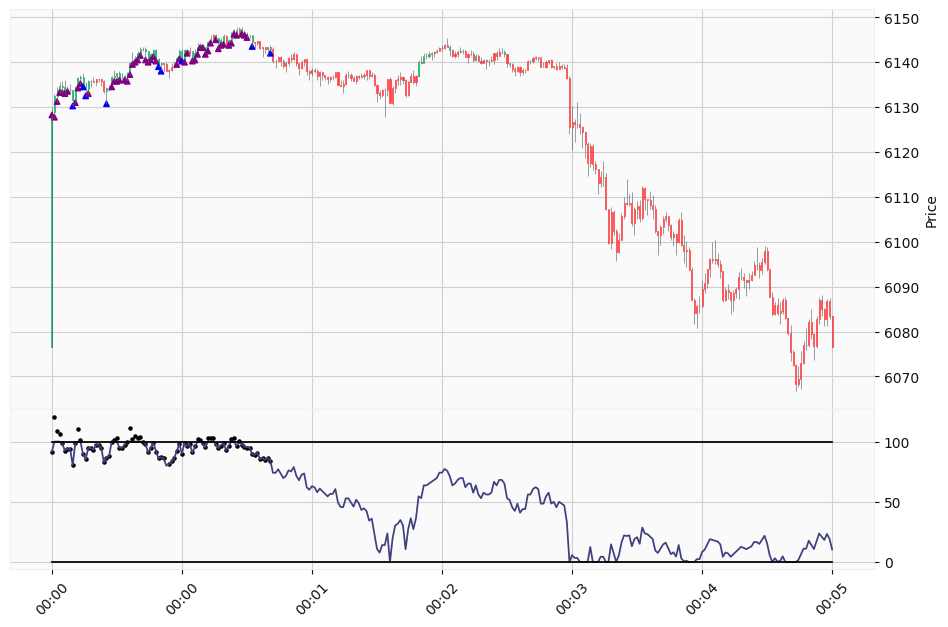

Plotting Features: ['hilo_stoch_240_120_spx']


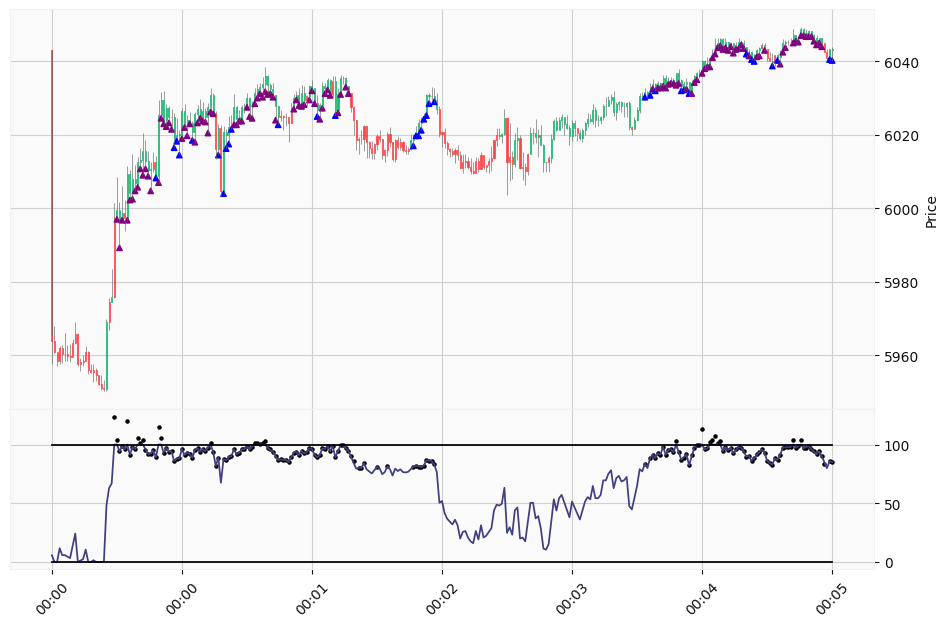

Plotting Features: ['hilo_stoch_240_120_spx']


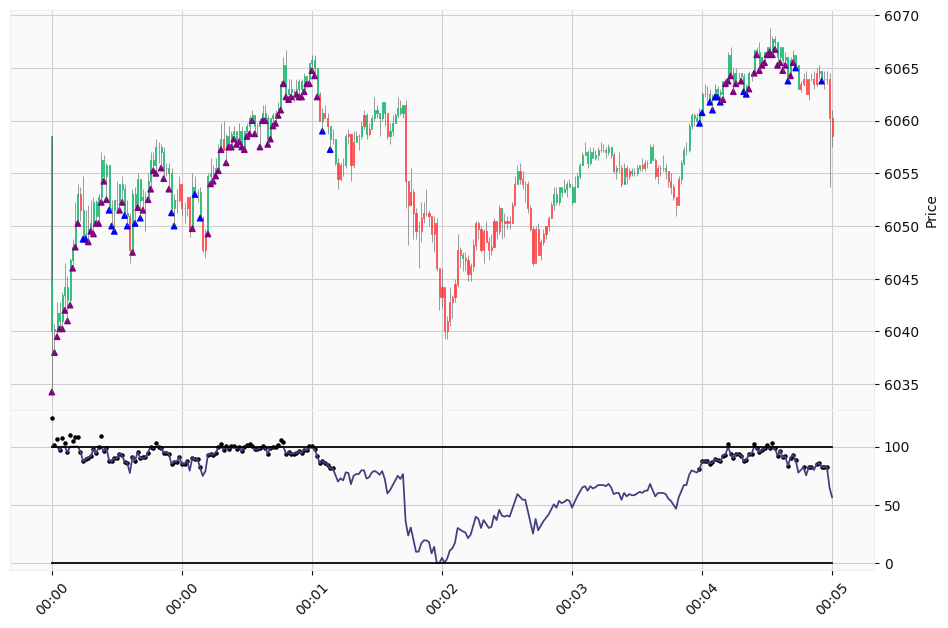

Plotting Features: ['hilo_stoch_240_120_spx']


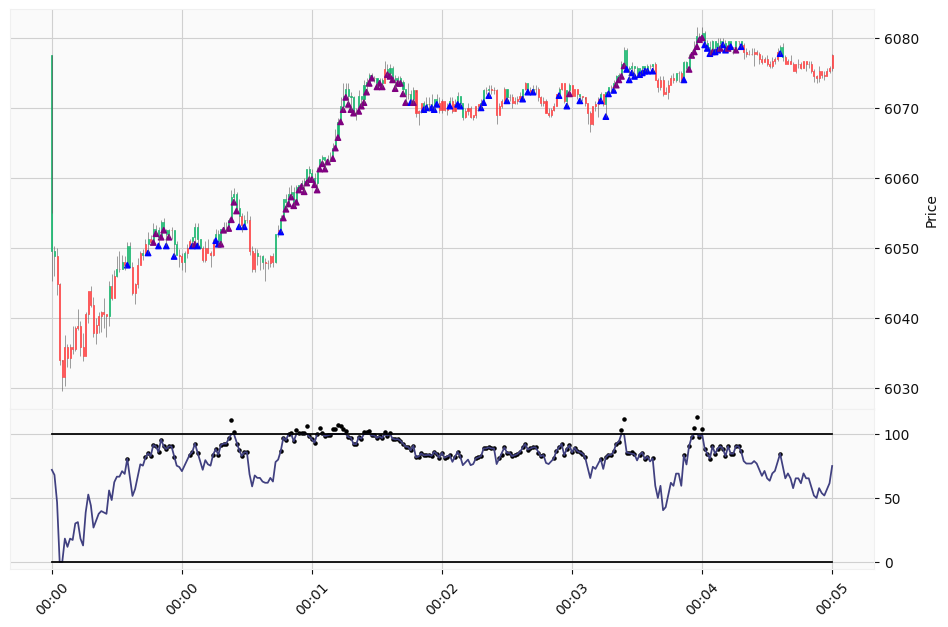

Plotting Features: ['hilo_stoch_240_120_spx']


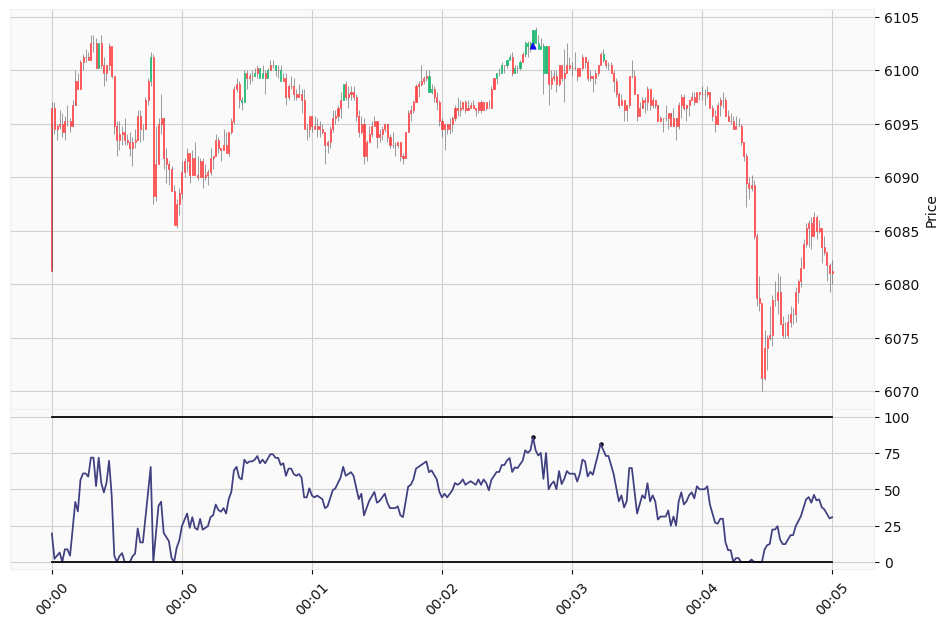

Plotting Features: ['hilo_stoch_240_120_spx']


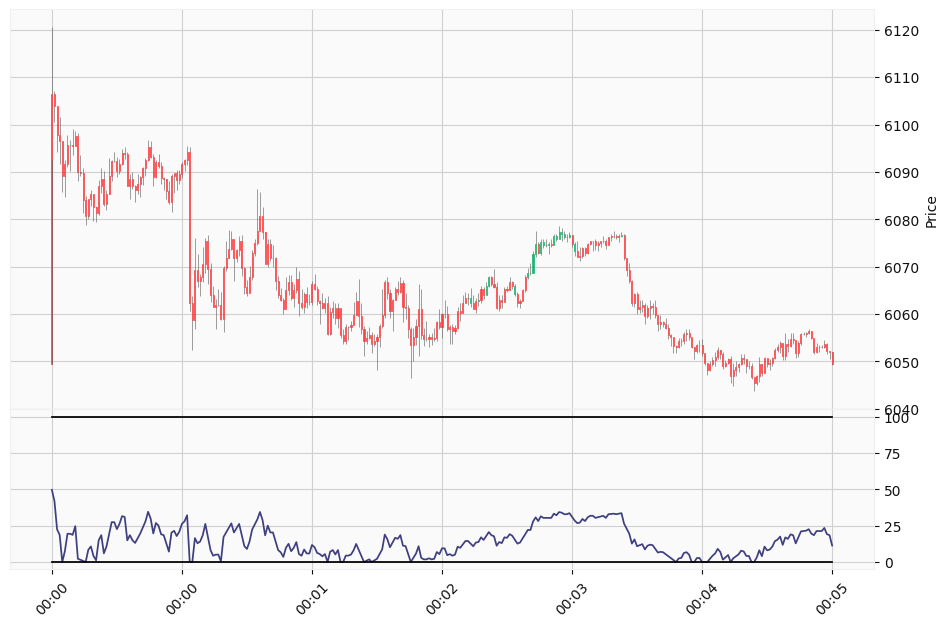

Plotting Features: ['hilo_stoch_240_120_spx']


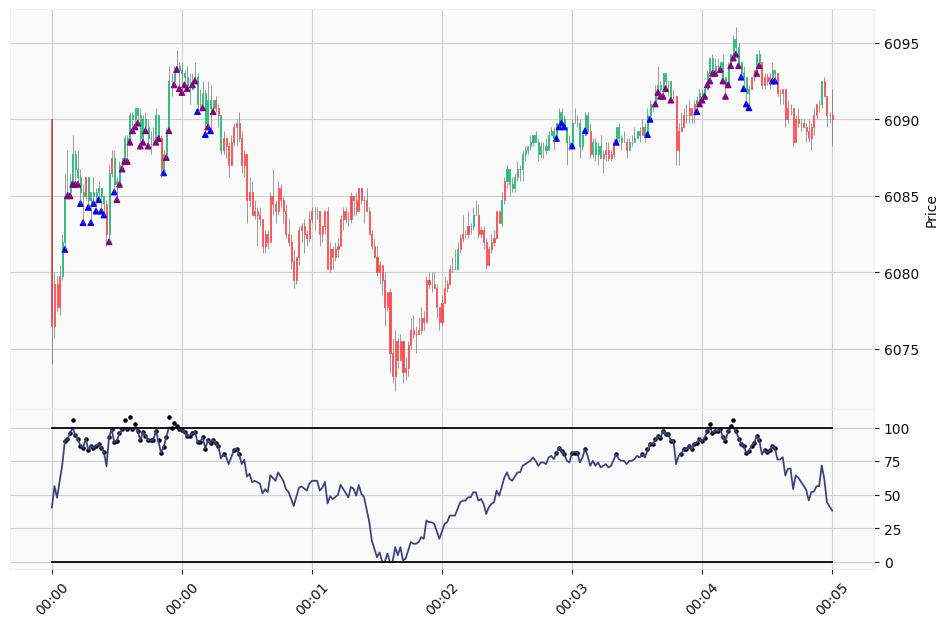

Plotting Features: ['hilo_stoch_240_120_spx']


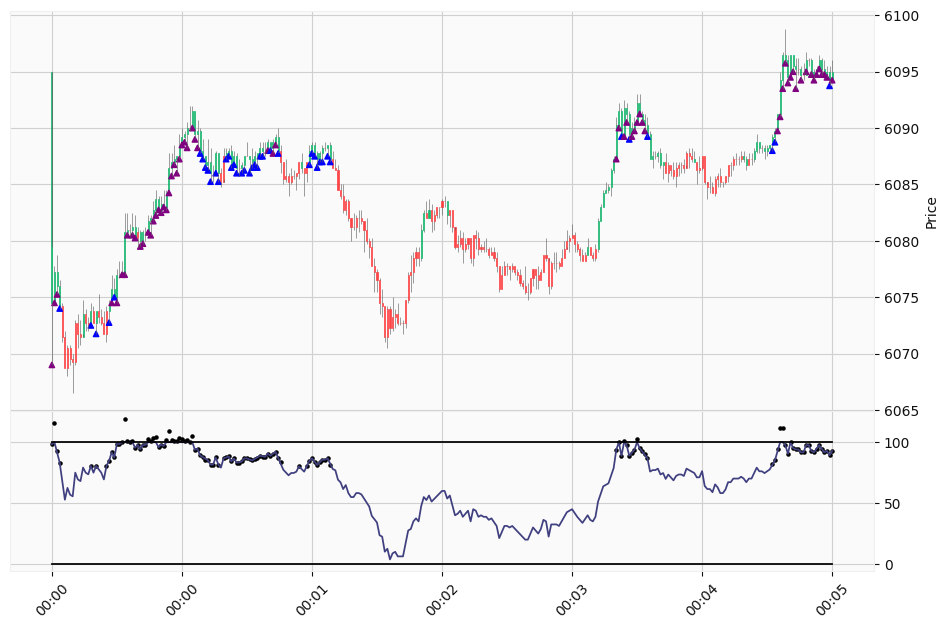

Plotting Features: ['hilo_stoch_240_120_spx']


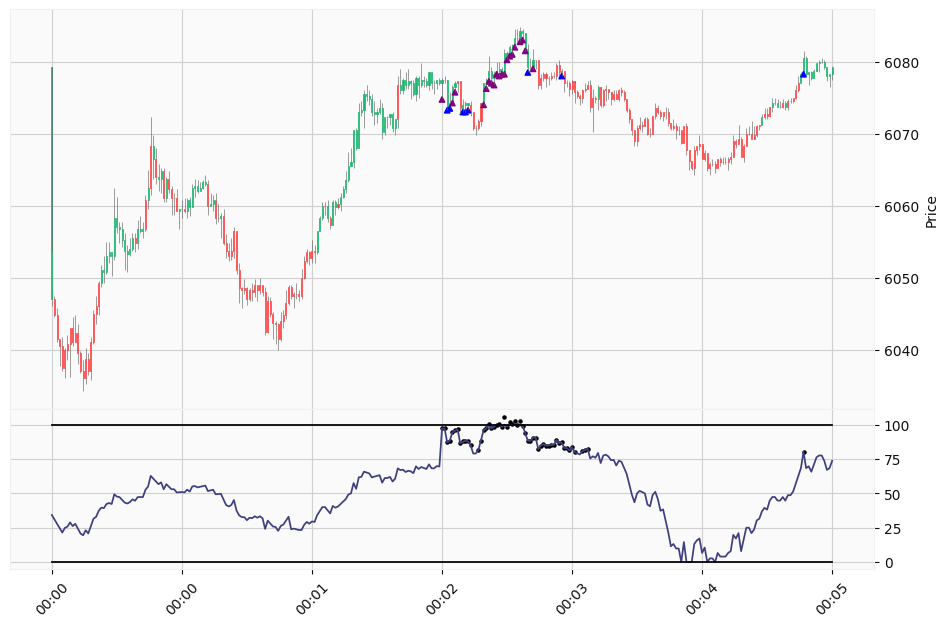

Plotting Features: ['hilo_stoch_240_120_spx']


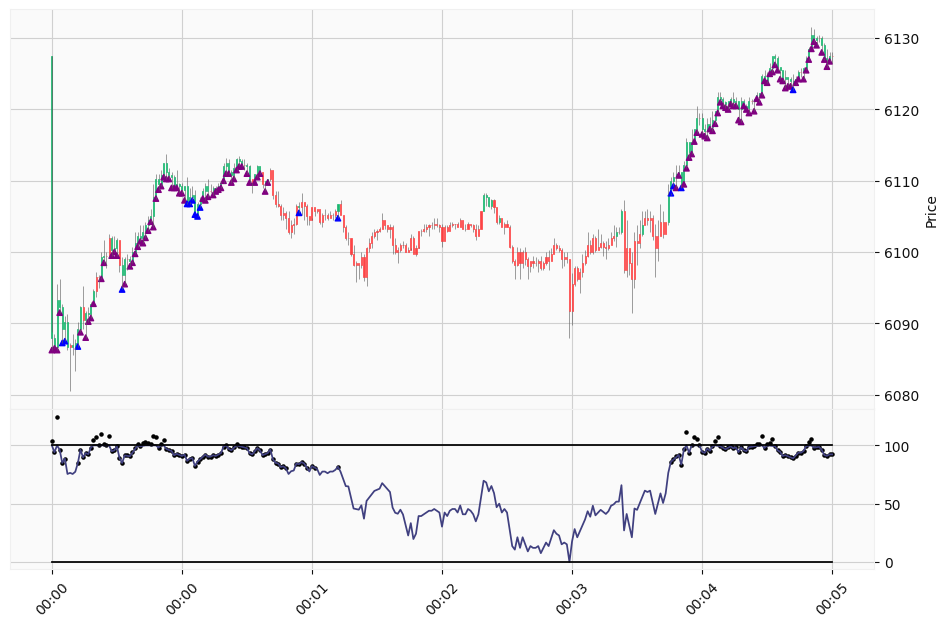

Plotting Features: ['hilo_stoch_240_120_spx']


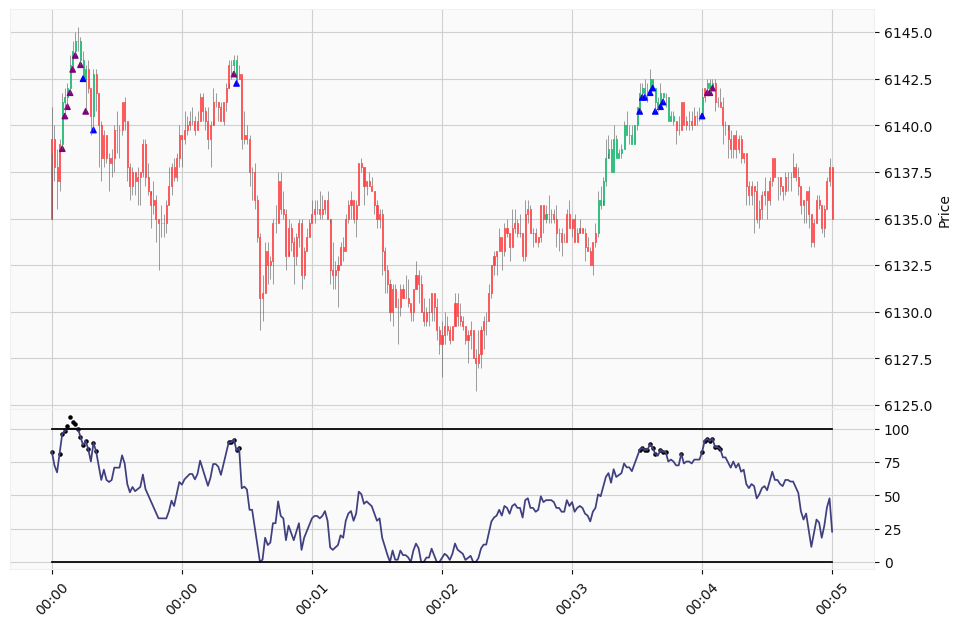

In [9]:
#showing chart of predictions
X_raw, _, _, __,\
y_raw, _, ___, ____,\
feature_subsets, scaler =\
_Data_Processing.preprocess_data(
	file_name   =		'spx_test2.csv'
	,indp_size  =		0.01
	,test_size  =		0.01
	,shfl_splt	=		False
	,t_start    =		600
	,t_end		=		950
	,mod_type	=		'Area_Classification'
	,target_t	=		60
	,num_class	=		2
	,split_val	=		5
	,verbose	=		0
	,scaler		=		'None'
    ,cstm_scale	=		joblib.load('scaler/tmp.joblib')
	,frmt_lstm	=		lstm_format
	,keep_price =		True
    ,keep_time	=		True
    ,indices	=		0
)

reload(_Utility)
signals = _Utility.show_predictions_chart(X_raw=X_raw,predictions=t_pred, t_start=600, t_end=900
                                , add_chart=[517]
                                , fss=feature_subsets
                                , naked_features=False
                                , signal=80)

In [ ]:
import numpy as np
reload(_Utility)
tpl = _Utility.backtester(
    X_raw=X_raw,
    signals=signals,
    method='time_held',
    value=(0,20),#(0,5,1.5,30),
    fees=None)

print(tpl)

#_Utility.graph_range(function=_Utility.backtester,
#	kw='value',
#	kw_range=[(0, i, 2, 30) for i in range(1,20)],
#    
#		#function specific parameteres
#        method='RR_ratio',
#		X_raw=X_raw,
#        signals=signals,
#        fees=None
#	)